In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris
import math

from scipy.stats import norm, laplace, gamma

from PACKAGE_NAME.variables import *
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import assumptions, correlation, marginal, spatial, trend
from PACKAGE_NAME.evaluate.metrics import *

**Set variables and metrics to investigate**

In [3]:
tas_metrics = [warm_days, cold_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]

# 1. Data import and pre-processing

In [4]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_validate = cm[:, :, 9001:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future


In [5]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_dates_validate, pr_dates_future = preprocess_isimip_evaluation_testing_data('pr')

# 2. Evaluation part one - test assumptions

## 2. 1. Parametric methods: goodness of fit assessment + seasonality

For all parametric methods, distributions are fitted to the CDFs. Default distributions are specified in the individual debiasers. In this evaluation step, the default distributions of the specified debiasers are fitted to the data so that the user can decide whether or not to go ahead with this particular distribution or method, or whether to modify it.

In the example below, the goodness of fit of the default distribution fitted to temperature data is assessed. 
- By calculating the Akaike Information Criterion and plotting the fit and distribution for the location with the worst fit for visual inspection. If a user modifies the distribution she can compare whether this improves the fit according to the AIC
- By evaluating the quantile residuals (timeseries, their autocorrelation and a qq-plot of their transformation to normal) - in this example we see that there is a strong seasonal effect present that the normal distribution does not capture.

**Distribution of AIC**

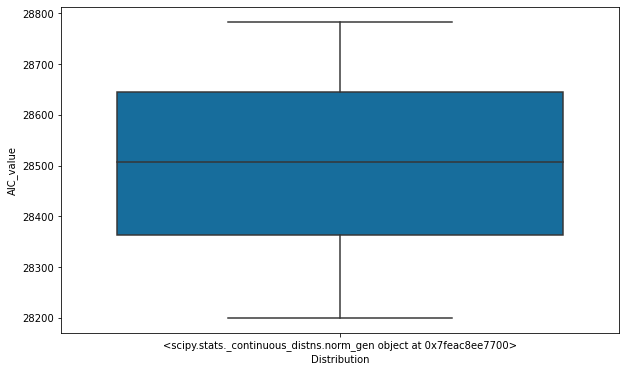

In [6]:
tas_obs_aic_default = assumptions.calculate_aic_goodness_of_fit(variable = 'tas', dataset = tas_obs_validate, 
                                                                distribution_names = [scipy.stats.norm])
assumptions.plot_aic_goodness_of_fit(variable = 'tas', aic_data = tas_obs_aic_default)

**Visual inspection of fit at 'worst' location**

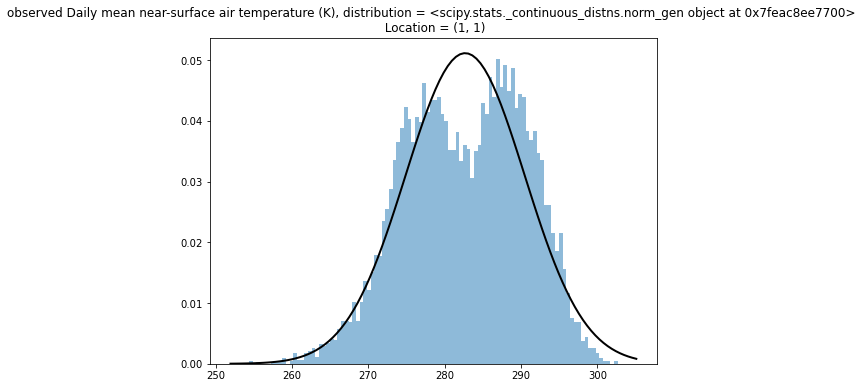

In [7]:
tas_obs_worst_fit = assumptions.plot_worst_fit_aic(variable = 'tas', dataset = tas_obs, 
                                      aic = tas_obs_aic_default, 
                                      data_type = 'observed', distribution_name = scipy.stats.norm)

**Inspection of quantile residuals**

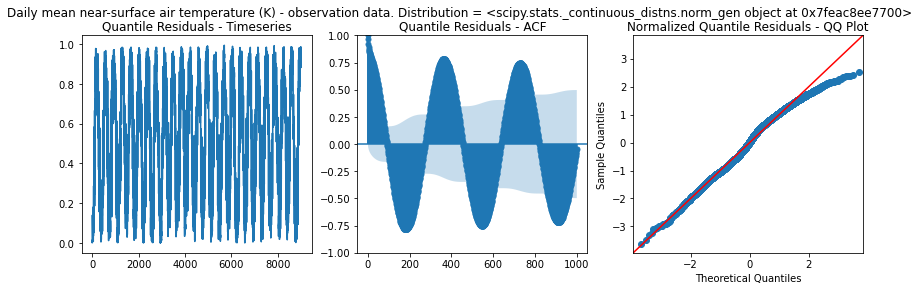

In [8]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(dataset = tas_obs[:,0,0], 
                                                        variable = 'tas', data_type = 'observation data',
                                                      distribution_name = scipy.stats.norm)

## 2. 2. Stationarity / Stability of results

End-of-august add-on?

# 3. Initialise and apply de-biasers

**Quantile Mapping**

In [25]:
# Temperature
tas_debiaser_QM = QuantileMapping.from_variable(variable=tas, detrending="additive")
tas_val_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_future)

# Also debias historical climate model using quantile mapping
tas_debiased_hist = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_hist)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 641.01it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 614.64it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 531.92it/s]


In [9]:
# Precipitation
hurdle_model = gen_PrecipitationHurdleModel(distribution = gamma)
left_censored_model = gen_PrecipitationGammaLeftCensoredModel(censoring_threshold = 0.1/86400)

pr_debiaser_QM = QuantileMapping.for_precipitation(detrending = "multiplicative", distribution = hurdle_model)
pr_val_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_future)

pr_debiased_hist = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_hist)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 116.54it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 71.39it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 96.94it/s]


**Equidistant CDF Matching**

In [10]:
# Temperature
tas_debiaser_ECDFM = ECDFM.from_variable(variable = "tas")
tas_val_debiased_ECDFM = tas_debiaser_ECDFM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_ECDFM = tas_debiaser_ECDFM.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]


In [11]:
# Precipitation
pr_debiaser_ECDFM = ECDFM.from_variable(variable = "pr")
pr_val_debiased_ECDFM = pr_debiaser_ECDFM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_ECDFM = pr_debiaser_ECDFM.apply(pr_obs, pr_cm_hist, pr_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 101.03it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 38.24it/s]


**ISIMIP**

In [12]:
# ISIMIP
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate)
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████████| 4/4 [00:13<00:00,  3.33s/it]


In [13]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate)
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.42s/it]


**CDFt**

In [14]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


In [15]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, **tas_dates_validate)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


**Delta Change**

In [16]:
tas_debiaser_DC = DeltaChange.from_variable(variable = "tas")
tas_val_debiased_DC = tas_debiaser_DC.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_DC = tas_debiaser_DC.apply(tas_obs, tas_cm_hist, tas_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1883.18it/s]


----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2993.79it/s]


In [17]:
pr_debiaser_DC = DeltaChange.from_variable(variable = "pr")
pr_val_debiased_DC = pr_debiaser_DC.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_DC = pr_debiaser_DC.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2506.31it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 882.59it/s]


**Linear Scaling**

In [18]:
tas_debiaser_LS = LinearScaling.from_variable(variable = "tas")
tas_val_debiased_LS = tas_debiaser_LS.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_LS = tas_debiaser_LS.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1129.32it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1914.77it/s]


In [19]:
pr_debiaser_LS = LinearScaling.from_variable(variable = "pr")
pr_val_debiased_LS = pr_debiaser_LS.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_LS = pr_debiaser_LS.apply(pr_obs, pr_cm_hist, pr_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1576.07it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1484.71it/s]


**Quantile Delta Mapping**

In [20]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 25%|███████████▎                                 | 1/4 [00:00<00:00,  3.29it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according

In [21]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
  0%|                                                     | 0/4 [00:00<?, ?it/s]WARNING:root:
                    QuantileDeltaMapping runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:333: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.38s/it]WARNING:root:
                    Qu

**Scaled Distribution Mapping**

In [22]:
tas_debiaser_SDM = ScaledDistributionMapping.from_variable(variable = "tas")
tas_val_debiased_SDM = tas_debiaser_SDM.apply(tas_obs, tas_cm_hist, tas_cm_validate)
tas_fut_debiased_SDM = tas_debiaser_SDM.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 208.88it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 129.24it/s]


In [23]:
pr_debiaser_SDM = ScaledDistributionMapping.from_variable(variable = "pr")
pr_val_debiased_SDM = pr_debiaser_SDM.apply(pr_obs, pr_cm_hist, pr_cm_validate)
pr_fut_debiased_SDM = pr_debiaser_SDM.apply(pr_obs, pr_cm_hist, pr_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 20311.40it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 13464.86it/s]


# 4. Evaluation of bias corrected results on validation period

After applying the bias correction methods chosen by the user, this section provides a default set of evaluation to assess both the performance of the bias corrected climate model, as well as to get an insight into potential larger biases of the underlying climate model that cannot be corrected through bias correction methods.

In order to assess the performance of a bias correction methods, we need underlying observations to compare the climate simulation to - this is not given in a future period that we actually want to apply bias correction to. We therefore split the historical period into a 'training' and a 'validation' period, and assess the performance of the BC on the validation period where results can still be compared to observations.

## 4. 1. Distribution of bias across locations

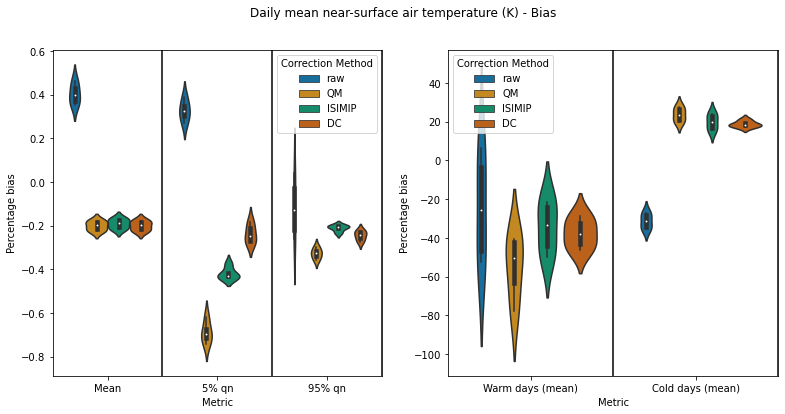

In [26]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,
                                                 obs_data = tas_obs_validate,
                                                 raw = tas_cm_validate, 
                                                 QM = tas_val_debiased_QM,
                                                 ISIMIP = tas_val_debiased_ISIMIP,
                                                 DC = tas_val_debiased_DC)

marginal.plot_marginal_bias(variable = 'tas', bias_array = tas_marginal_bias_data)

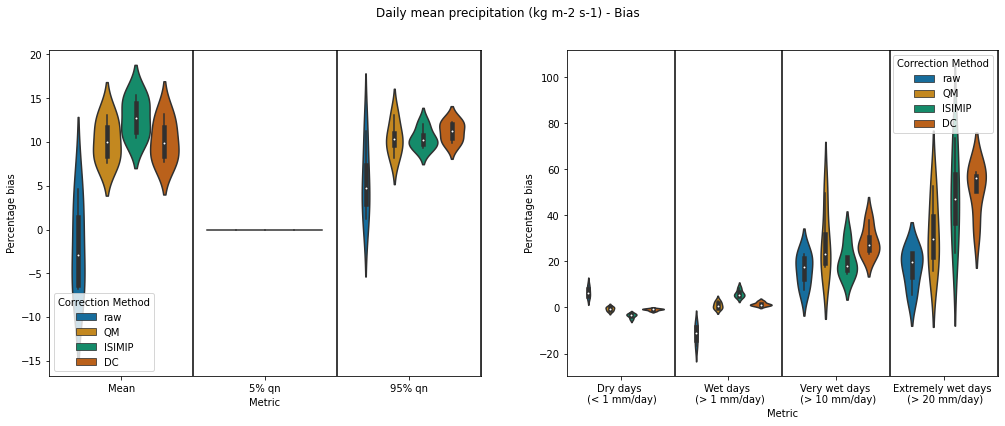

In [27]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics, obs_data = pr_obs_validate,
                                                 raw = pr_cm_validate, 
                                                 QM = pr_val_debiased_QM,
                                                 ISIMIP = pr_val_debiased_ISIMIP,
                                                 DC = pr_val_debiased_DC)
marginal.plot_marginal_bias(variable = 'pr', bias_array = pr_marginal_bias_data)

In [ ]:
# visual inspection of histograms possible

## 4.2. Visualisation of spatial distribution

The shape of the distribution in the violinplot above already gives an indication of whether the bias is especially large over certain areas. The following plot explicitely shows the spacial distribution of biases. Particularly high biases in a certain region could point to deficiencies in the underlying climate model (for example, there could be a mountain range over which the climate model performs particularly badly, or other land-atmosphere interactions that are not captured).

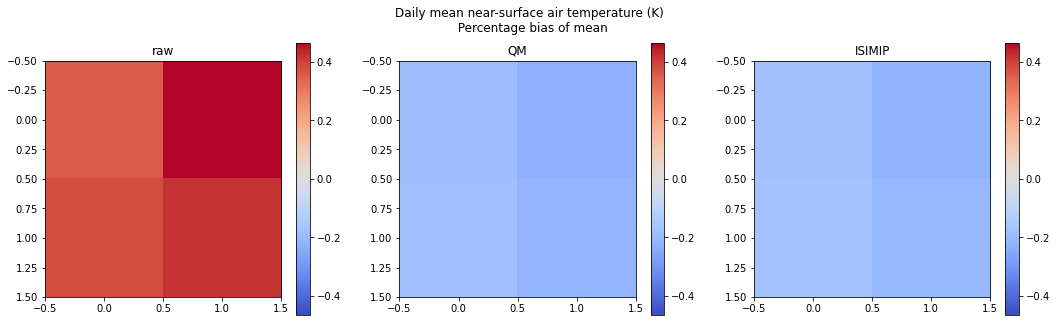

In [28]:
tas_bias_map_mean = spatial.plot_bias_spatial(variable = 'tas', statistic = 'mean', metric = None, obs_data = tas_obs_validate,
                                              raw = tas_cm_validate, QM = tas_val_debiased_QM, 
                                              ISIMIP = tas_val_debiased_ISIMIP)

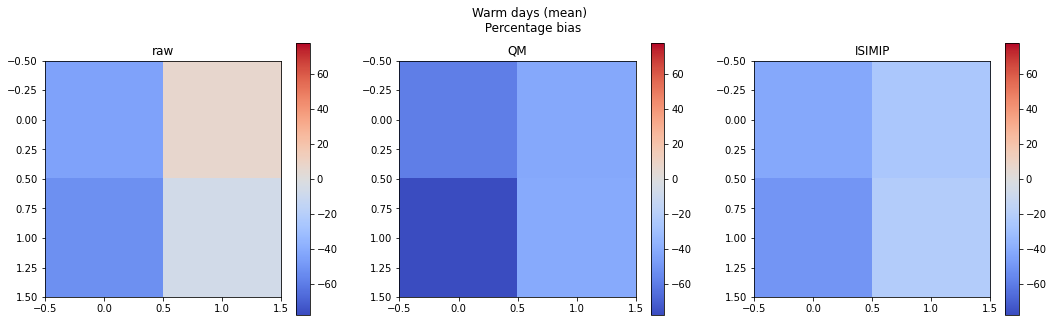

In [29]:
tas_bias_map_mean = spatial.plot_bias_spatial(variable = 'tas', statistic = 'metric', metric = warm_days, obs_data = tas_obs_validate,
                                              raw = tas_cm_validate, QM = tas_val_debiased_QM, 
                                              ISIMIP = tas_val_debiased_ISIMIP)

## 4.3. Spatiotemporal extent

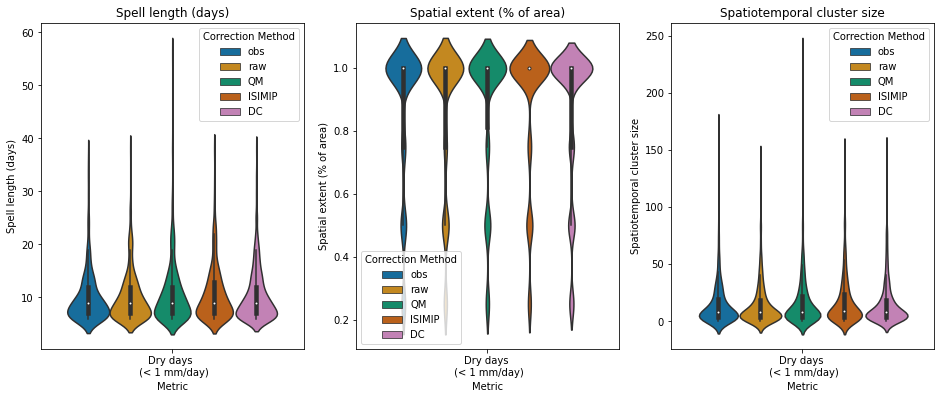

In [30]:
dry_days.plot_clusters_violinplots(minimum_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

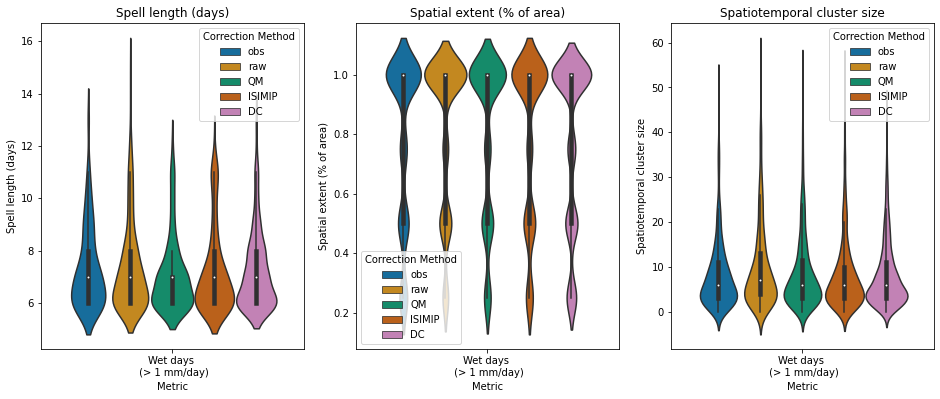

In [31]:
wet_days.plot_clusters_violinplots(minimum_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

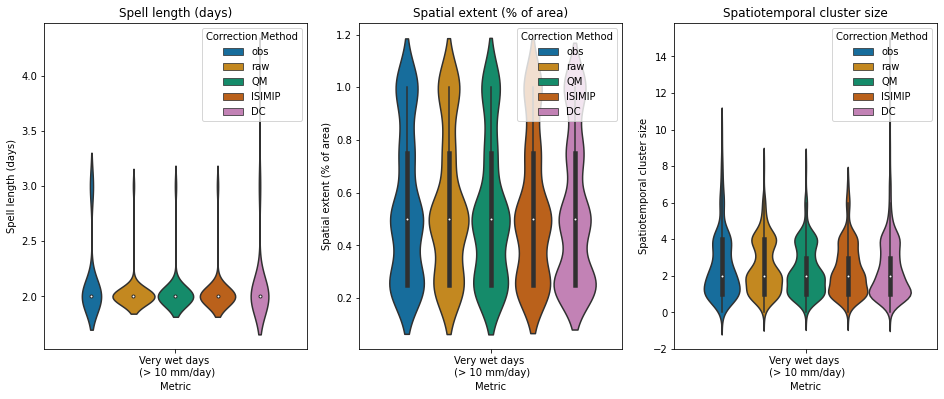

In [32]:
R10mm.plot_clusters_violinplots(minimum_length = 1, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

## 4.4. Correlation

### Spatial correlation - distribution of RMSE between two correlation matrices

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_73083/3358555626.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


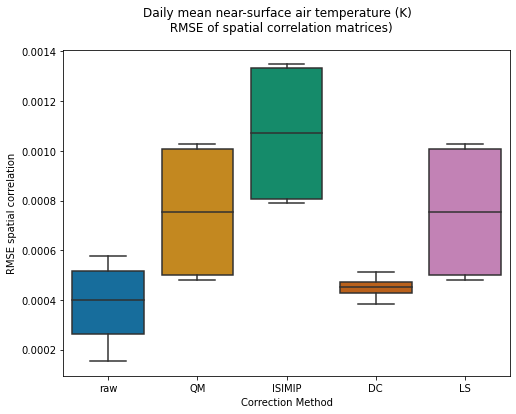

In [33]:
tas_rmsd_spatial = correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                         obs_data = tas_obs_validate, raw = tas_cm_future,
                                                         QM = tas_val_debiased_QM,ISIMIP = tas_val_debiased_ISIMIP,
                                                         DC = tas_val_debiased_DC, LS = tas_val_debiased_LS)
tas_rmsd_spatial_plot = correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

### Multivariate structure - difference in correlation matrices - open questions

**Spatial plot of locationwise correlation (Pearson) between temperature and precipitation**

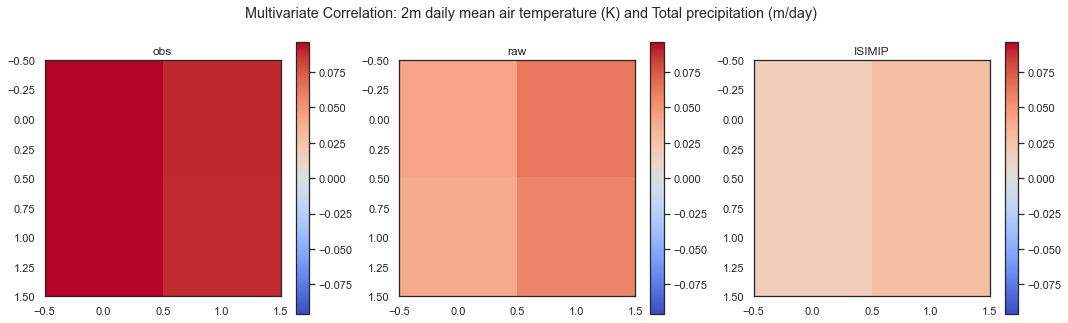

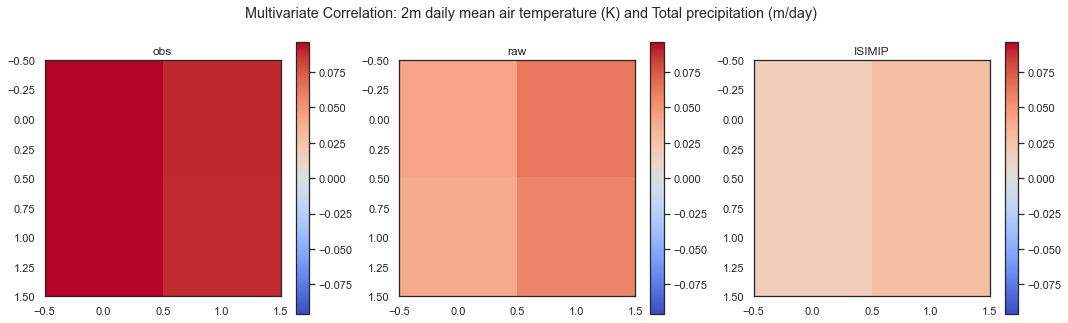

In [215]:
correlation.calculate_multivariate_correlation_locationwise(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

**Investigation into one locations shows that relationship is not really linear**

<AxesSubplot:xlabel='tas', ylabel='pr'>

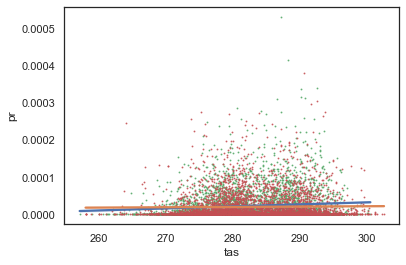

In [236]:
import seaborn
import pandas as pd

obs_dataset = pd.DataFrame(columns=['tas', 'pr'])
obs_dataset['tas'] = tas_obs_validate[:, 0,0]
obs_dataset['pr'] = pr_obs_validate[:, 0,0]

isimip_dataset = pd.DataFrame(columns=['tas', 'pr'])
isimip_dataset['tas'] = tas_val_debiased_ISIMIP[:, 0,0]
isimip_dataset['pr'] = pr_val_debiased_ISIMIP[:, 0,0]

seaborn.set_style('white')

seaborn.regplot(x="tas", y="pr", data=obs_dataset, ci=95, scatter_kws={'s': 0.8, 'color':'g'}) 
           #line_kws={'lw': 2, 'color': '#4682b4'})
seaborn.regplot(x="tas", y="pr", data=isimip_dataset, ci=95, scatter_kws={'s': 0.8, 'color':'r'})     

**Bootstrapping applied to correlation estimate, then KS test to see whether correlation coefficient of observed and bias corrected data can have been drawn from the same distribution**

KstestResult(statistic=0.998, pvalue=7.399507995628047e-297)

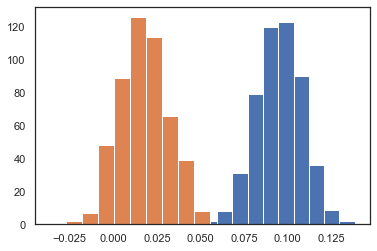

In [219]:
from scipy.stats import kstest

def draw_bs_replicates(data,size):

    corr_replicates = np.empty(size)

    for i in range(size):
        
        bs_sample = data.sample(n=data.shape[0], replace=True)
        
        corr_replicates[i] = bs_sample['pr'].corr(bs_sample['tas'])
    
    return corr_replicates

corr_estimates_obs = draw_bs_replicates(obs_dataset, 500)
corr_estimates_isimip = draw_bs_replicates(isimip_dataset, 500)

plt.hist(corr_estimates_obs)
plt.hist(corr_estimates_isimip)

kstest(corr_estimates_obs, corr_estimates_isimip, 'auto')

**Exploration of mutual information instead of correlation - currently very dependent on bin size of constructed histogram**

(array([  9.,  59., 121.,  82.,  45.,  54.,  74.,  33.,  16.,   7.]),
 array([0.17007672, 0.17848011, 0.1868835 , 0.1952869 , 0.20369029,
        0.21209368, 0.22049707, 0.22890046, 0.23730385, 0.24570724,
        0.25411063]),
 <BarContainer object of 10 artists>)

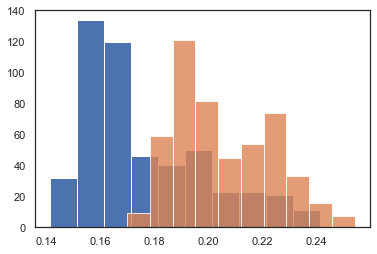

In [237]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def draw_bs_replicates_mi(data,bins, size):

    corr_replicates = np.empty(size)

    for i in range(size):
        
        bs_sample = data.sample(n=data.shape[0], replace=True).to_numpy()
        
        corr_replicates[i] = calc_MI(bs_sample[:, 0], bs_sample[:, 1], bins)
    
    return corr_replicates

mi_estimates_obs = draw_bs_replicates_mi(obs_dataset, 50, 500)
mi_estimates_isimip = draw_bs_replicates_mi(isimip_dataset, 50, 500)

plt.hist(mi_estimates_obs)
plt.hist(mi_estimates_isimip, alpha=0.8)

# 5. Trend preservation

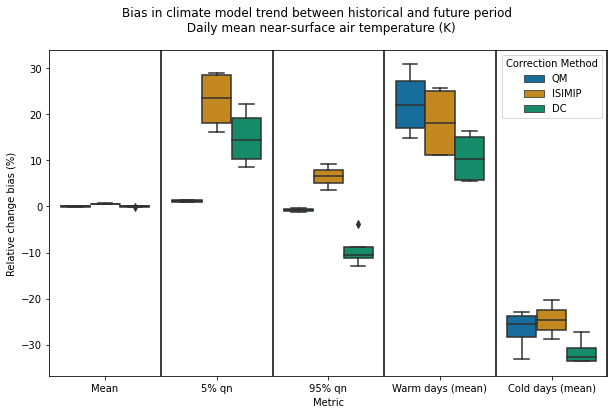

In [34]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', metric_collection = tas_metrics, 
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future, 
                                                  QM = [tas_val_debiased_QM, tas_fut_debiased_QM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  DC = [tas_val_debiased_DC, tas_fut_debiased_DC])

trend.plot_future_trend_bias(variable ='tas', bias_array = tas_trend_bias_data)

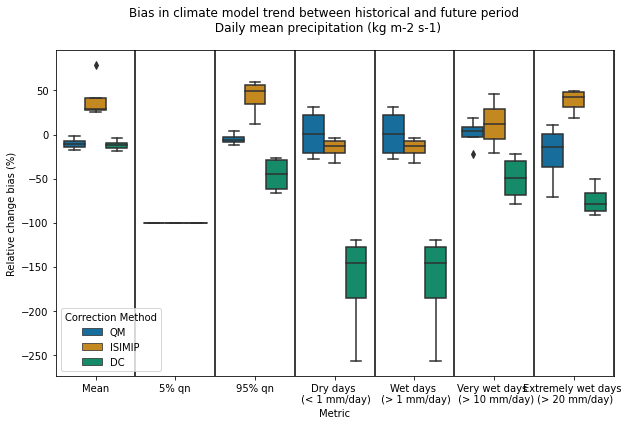

In [36]:
pr_trend_bias_data = trend.calculate_future_trend_bias(variable = 'pr', metric_collection = pr_metrics, 
                                                  raw_validate = pr_cm_validate, raw_future = pr_cm_future, 
                                                  QM = [pr_val_debiased_QM, pr_fut_debiased_QM],
                                                  ISIMIP = [pr_val_debiased_ISIMIP, pr_fut_debiased_ISIMIP],
                                                  DC = [pr_val_debiased_DC, pr_fut_debiased_DC])

trend.plot_future_trend_bias(variable ='pr', bias_array = pr_trend_bias_data)